# EX3: GW150914
In this example we load an LVK posterior from zenodo and compute the FI evidence for the CBC model.

Download posteriors from [zenodo](https://zenodo.org/record/6513631/files/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5?download=1)

In [92]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import h5py
import numpy as np
import pandas as pd
from collections import namedtuple
from funnel.plotting import plot_fi_evidence_results
from funnel.fi_core import get_fi_lnz_list
import shutil, os

np.random.seed(42)

## Load GW150914 posterior + Nested Sampling LnZ

In [107]:
# load the LVK posterior
FPATH = 'IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5'

LVK_data = namedtuple("LVK_data", "posterior, lnz, lnz_err, lnBF")


def load_lvk_data(fpath):
    with h5py.File(fpath, 'r') as f:
        sampling_params = list(f['C01:IMRPhenomXPHM/priors/analytic'].keys())
        sampler_data = f['C01:IMRPhenomXPHM/meta_data/sampler']
        lnz, lnz_err =  sampler_data['ln_evidence'][0], sampler_data['ln_evidence_error'][0]
        lnBF = sampler_data['ln_bayes_factor'][0]
        post = f['C01:IMRPhenomXPHM']['posterior_samples'][()]
        post = pd.DataFrame({name: post[name][:] for name in post.dtype.names})
        post = post[sampling_params + ['log_likelihood', 'log_prior']]
        # only keep parameters with more than one unique value (ie drop deltas)
        post = post.loc[:, post.nunique() > 1]
    return LVK_data(post, lnz, lnz_err, lnBF)


GW150914_data = load_lvk_data(FPATH)

In [108]:
print(f"LnZ: {GW150914_data.lnz:.2f} +/- {GW150914_data.lnz_err:.2f}")
print(f"LnBF: {GW150914_data.lnBF}")
GW150914_data.posterior.head()

LnZ: -6984.67 +/- 0.14
LnBFL: 303.45


,a_1,a_2,azimuth,chirp_mass,geocent_time,luminosity_distance,mass_1,mass_2,mass_ratio,phase,...,recalib_L1_phase_7,recalib_L1_phase_8,recalib_L1_phase_9,theta_jn,tilt_1,tilt_2,time_jitter,zenith,log_likelihood,log_prior
0,0.924210,0.331092,3.278707,29.180724,1.126259e+09,323.733223,37.815124,29.796750,0.787959,3.840744,...,0.007216,-0.008044,0.012153,2.775318,1.913304,1.676054,0.000228,2.326161,322.304271,76.937960
1,0.647369,0.313305,2.602855,29.953047,1.126259e+09,510.955362,37.032017,32.002137,0.864175,4.337254,...,-0.003571,0.001302,-0.007935,2.660558,1.841044,1.839976,0.000325,2.334247,320.301483,78.620833
2,0.205678,0.875008,2.715020,31.433890,1.126259e+09,500.928555,39.143076,33.351053,0.852029,1.757881,...,0.002202,0.005764,-0.002742,2.493798,2.365895,1.369656,0.000120,2.345314,320.654009,76.031577
3,0.711251,0.004800,2.380721,30.741031,1.126259e+09,578.011396,35.664826,34.963693,0.980341,4.723087,...,-0.009888,0.005924,0.010894,2.967835,1.672429,0.627161,-0.000270,2.369513,324.265661,81.326038
4,0.250640,0.227152,2.783846,31.270597,1.126259e+09,587.119007,37.250081,34.647430,0.930130,5.542601,...,0.000942,-0.014119,0.010260,3.074509,1.373358,1.525285,0.000435,2.339495,322.729426,62.266597


NOTE: the `log-likelihood` column is actually the `lnl-noise Lnl` (the `log-likelihood-ratio`).

## Compute FI LnZ

In [145]:
OUTDIR = 'out_GW150914'
CLEAN = True
if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

# USING DOWNSAMPLED POSTERIOR SAMPLES AND A FEW REFERENCE POINTS FOR SPEED
N_SAMP = 5000
N_REF_POINTS = 100
post = GW150914_data.posterior.sample(N_SAMP, weights=np.exp(GW150914_data.posterior.log_likelihood))
print(f"Using {100*(len(post)/len(GW150914_data.posterior)):.2f}% of posterior samples, and trying out {N_REF_POINTS} reference points.")
lnzs, r_vals = get_fi_lnz_list(
    post,
    num_ref_params=N_REF_POINTS,
    r_vals=np.geomspace(10, 1e9, 100),
    cache_fn=f'{OUTDIR}/lnzs.npz',
)

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (5000, 58) 


Using 3.39% of posterior samples, and trying out 100 reference points.


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

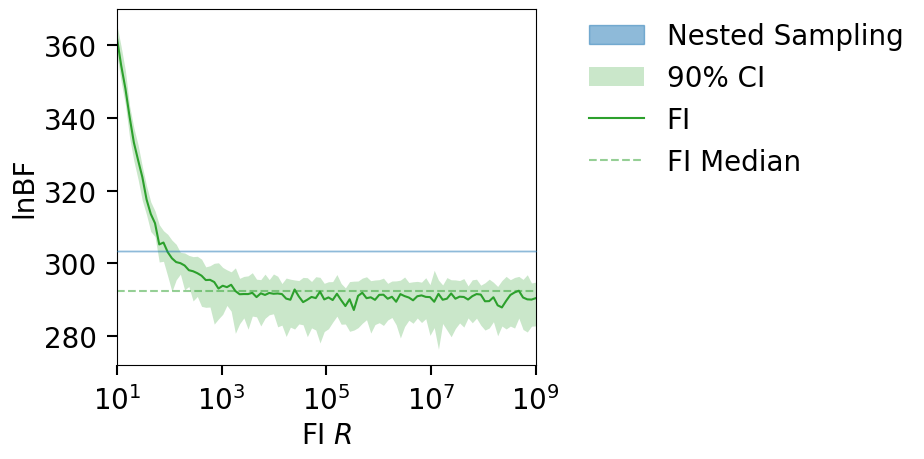

In [146]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals,sampling_lnz=[GW150914_data.lnBF])
fig = plot_fi_evidence_results(**plt_kwgs)
fig.gca().set_ylabel("lnBF");

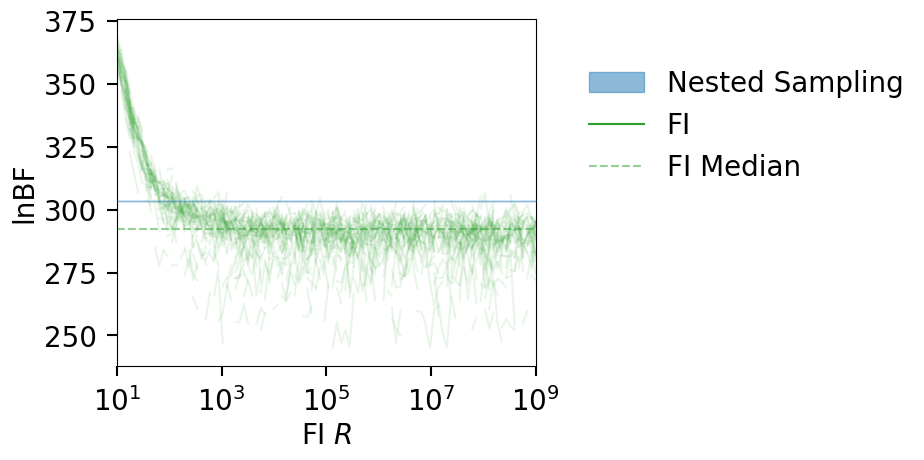

In [147]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True, plt_kwgs=dict(alpha=.1))
fig.gca().set_ylabel("lnBF");